# FORGE Geothermal Site

This example utilizes data available from the [FORGE geothermal reserach site](https://utahforge.com)'s [2019 Geothermal Design Challenge](https://utahforge.com/studentcomp/). In this example, the data is archived in the [Open Mining Format v1 (OMF)](https://github.com/gmggroup/omf) specification and the [`omfvista`](https://opengeovis.github.io/omfvista/) software is leverage to load those data into a PyVista `MultiBlock` data structure.

The goal of this workflow is to create a 3D temperature model by kriging the *Observed Temperature* data (sparse observational data).
The open-source, Python software [GSTools](https://geostat-framework.github.io/) is used to perform variogram analysis and kriging of the temperature data onto a PyVista mesh to create the 3D model.

In [1]:
import pyvista as pv
import numpy as np
import omfvista
import PVGeo
import matplotlib.pyplot as plt
from gstools import Exponential, krige, vario_estimate_unstructured
from gstools.covmodel.plot import plot_variogram

## Load the Data

For this project, we have two data archives in the [Open Mining Format (OMF)](https://github.com/gmggroup/omf) specification and we will use one of PyVista's companion projects, [`omfvista`](https://opengeovis.github.io/omfvista/) to load those data archives into PyVista a `MultiBlock` dataset.

In [2]:
project = omfvista.load_project("data/FORGE.omf")
project

MultiBlock (0x7fb4f1d01408)
  N Blocks:	7
  X Bounds:	329924.988, 344152.930
  Y Bounds:	4252833.482, 4270951.098
  Z Bounds:	-2606.000, 2906.000

## Initial Inspection

Now we can go ahead and create an integrated visualization of all of the data available to us.

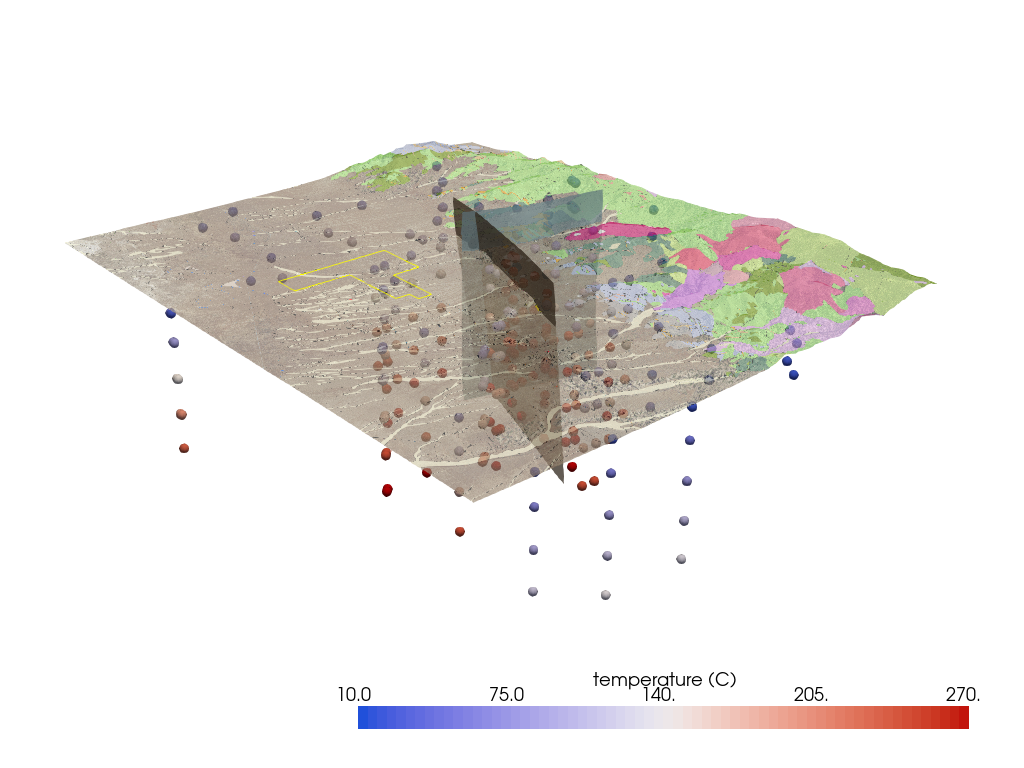

In [3]:
p = pv.Plotter(notebook=True)
p.add_mesh(project["Site Boundary"],
           color="yellow", render_lines_as_tubes=True)
p.add_mesh(project["Terrain"],
           texture="geo_aer", opacity=0.7, lighting=False)
p.add_mesh(project["Opal Mound Fault"],
           color="brown", opacity=0.7)
p.add_mesh(project["Negro Mag Fault"],
           color="lightblue", opacity=0.7)
p.add_mesh(project["Observed Temperature"],
           cmap="coolwarm", clim=[10,270], point_size=10,
           render_points_as_spheres=True)

p.enable_anti_aliasing()
p.enable_depth_peeling()
p.camera_position = [(315661.9406719345, 4234675.528454831, 15167.291249498076), 
                     (337498.00521202036, 4260818.504034578, -1261.5688408692681), 
                     (0.2708862567924439, 0.3397398234107863, 0.9006650255615491)]
p.show()

## Kriging

Now we will use an external library, [`gstools`](https://geostat-framework.github.io), to krige the temperature probe data into a 3D temperature model of the subsurface.



### Choosing a Model Space

We start out by creating the 3D model space as a PyVista `UniformGrid` that encompasses the project region. The following were chosen manually:

In [4]:
# Create the kriging grid
grid = pv.UniformGrid()
# Bottom south-west corner
grid.origin = (329700, 4252600, -2700)
# Cell sizes
grid.spacing = (250, 250, 50)
# Number of cells in eaxh direction
grid.dimensions = (60, 75, 100)

And the model can be visualized along side available data to ensure it covers the region of interest.

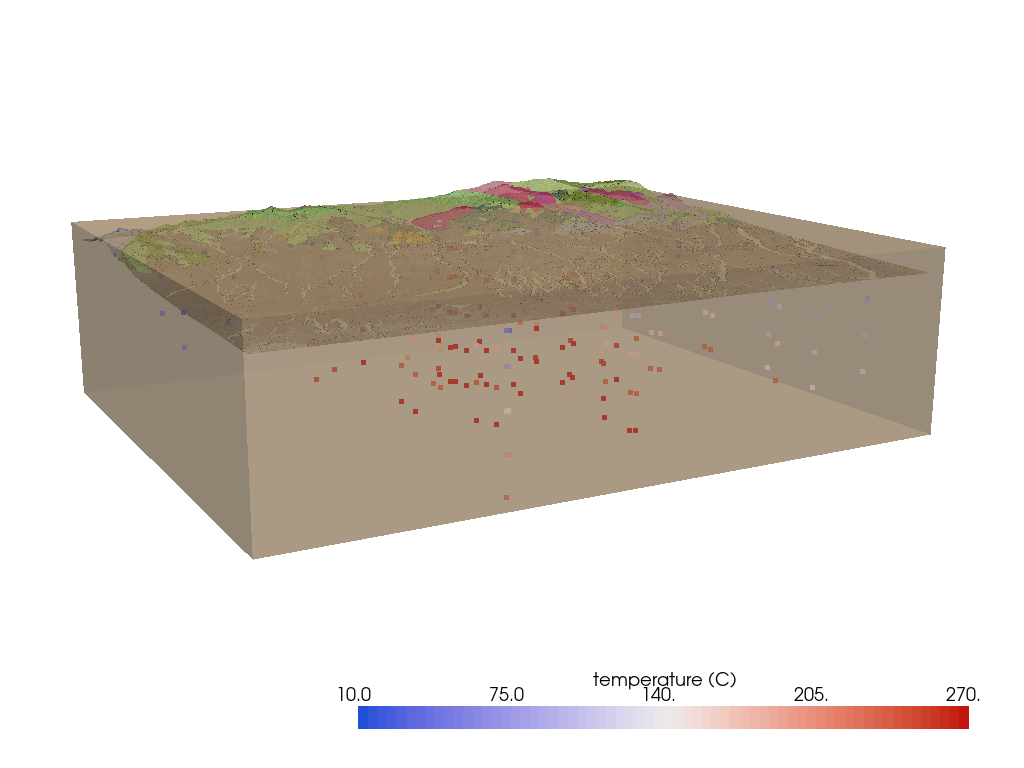

In [5]:
# Visually inspect the kriging grid in relation to data
p = pv.Plotter(notebook=True)
p.add_mesh(grid, opacity=0.5, color=True)
p.add_mesh(project["Terrain"],
           texture="geo_aer", opacity=0.75)
p.add_mesh(project["Observed Temperature"],
           cmap="coolwarm", stitle="Temperature (C)")

p.enable_depth_peeling()
p.camera_position = [(303509.4197523619, 4279629.689766085, 8053.049483835099), 
                     (336316.405356571, 4261479.748583805, -1756.358124546427), 
                     (0.22299463811939535, -0.11978828465250713, 0.9674317331109259)]
p.show()

### Variogram Analysis

Next, we need to compute a variogram for the temperature probe data and fit that variogram to an exponential model

/Users/bane/Software/external/GSTools/gstools/covmodel/plot.py:120: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


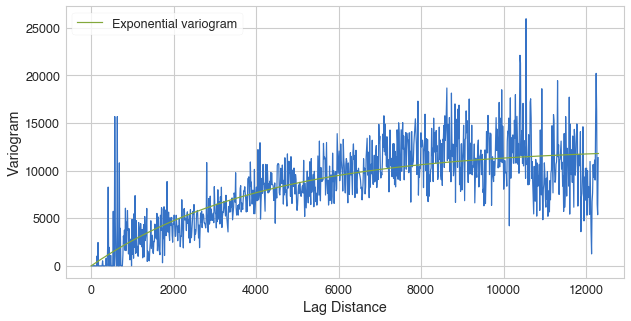

In [6]:
bins = np.linspace(0, 12300, 1000)
bin_center, gamma = vario_estimate_unstructured(
    project["Observed Temperature"].points.T,
    project["Observed Temperature"]["temperature (C)"],
    bins,
    )


fit_model = Exponential(dim=3)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

plt.figure(figsize=(10,5))
plt.plot(bin_center, gamma)
plot_variogram(fit_model, x_max=bins[-1], ax=plt.gca())
plt.xlabel("Lag Distance")
plt.ylabel("Variogram")
plt.show()

### Perfroming the Kriging

Then we pass the fitted exponential model when instantiating the kriging operator from GSTools.

In [7]:
# Create the kriging model
krig = krige.Ordinary(fit_model,
                      project["Observed Temperature"].points.T, 
                      project["Observed Temperature"]["temperature (C)"])

After instantiating the kriging operator, we can have it operate on the nodes of our 3D grid that we created earlier and collect the results back onto the grid.

In [8]:
# # In a Pull Request
# krig.mesh(grid, name="temperature (C)", )

In [9]:
# Run the kriging
krige_field, krige_var = krig(grid.points.T)

grid["temperature (C)"] = krige_field.ravel(order="f")
grid["krige_var"] = krige_var.ravel(order="f")

And now the `grid` model has the temperature scalar field and kriging variance as data arrays.

## Post-Processing

We can use a filter from PVGeo to extract the region of the temperature model that is beneath the topography surface as the kriging did not account for the surface boundary.

In [10]:
# Instantiate the algorithm
extractor = PVGeo.grids.ExtractTopography(tolerance=10, 
                                          remove=True)
# Apply the algorithm to the PyVista grid using the topography surface
subsurface = extractor.apply(grid, project["Terrain"])

## Resulting Visualization

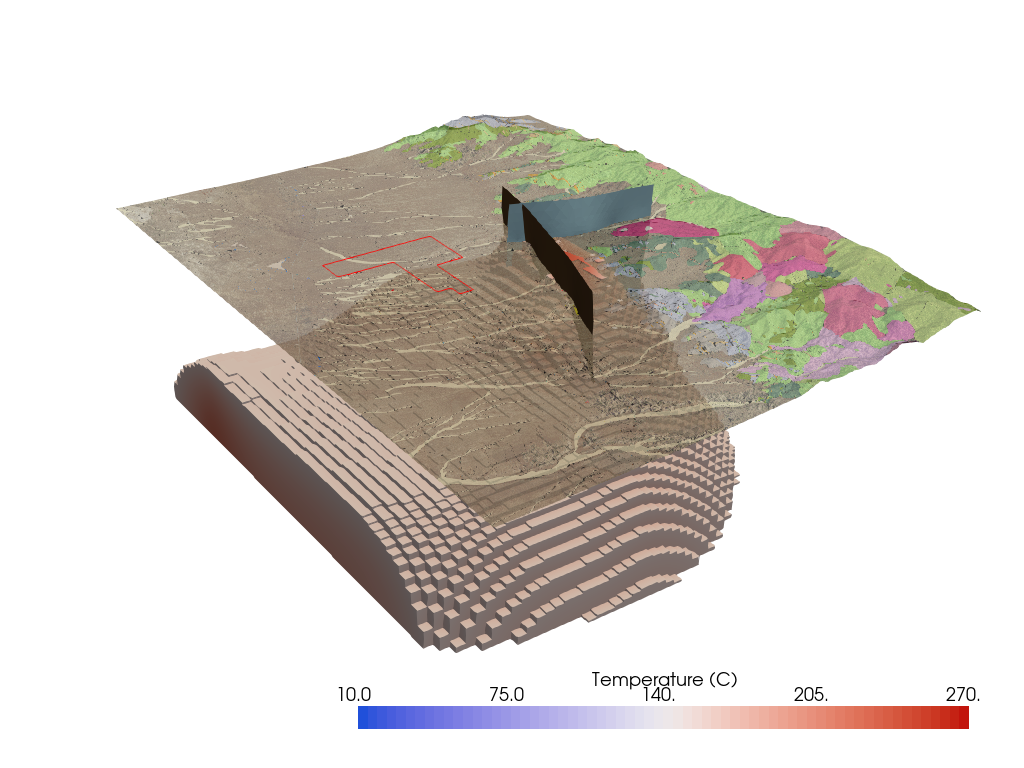

In [11]:
p = pv.Plotter(notebook=True)

p.add_mesh(project["Site Boundary"], color="red")
p.add_mesh(project["Terrain"], texture="geo_aer", opacity=0.75)
p.add_mesh(project["Opal Mound Fault"], color="brown")
p.add_mesh(project["Negro Mag Fault"], color="lightblue")

p.add_mesh(subsurface.threshold(150), scalars="temperature (C)", 
           cmap="coolwarm", clim=[10,270], stitle="Temperature (C)")

p.camera_position = [(316633.66018317704, 4235015.085729, 17393.58048567886),
                     (336531.1056580009, 4261160.391342634, -1333.1647888554417),
                     (0.2614279837556353, 0.42260518387264484, 0.8677904515915299)]

p.enable_anti_aliasing()
p.enable_depth_peeling()
p.show()

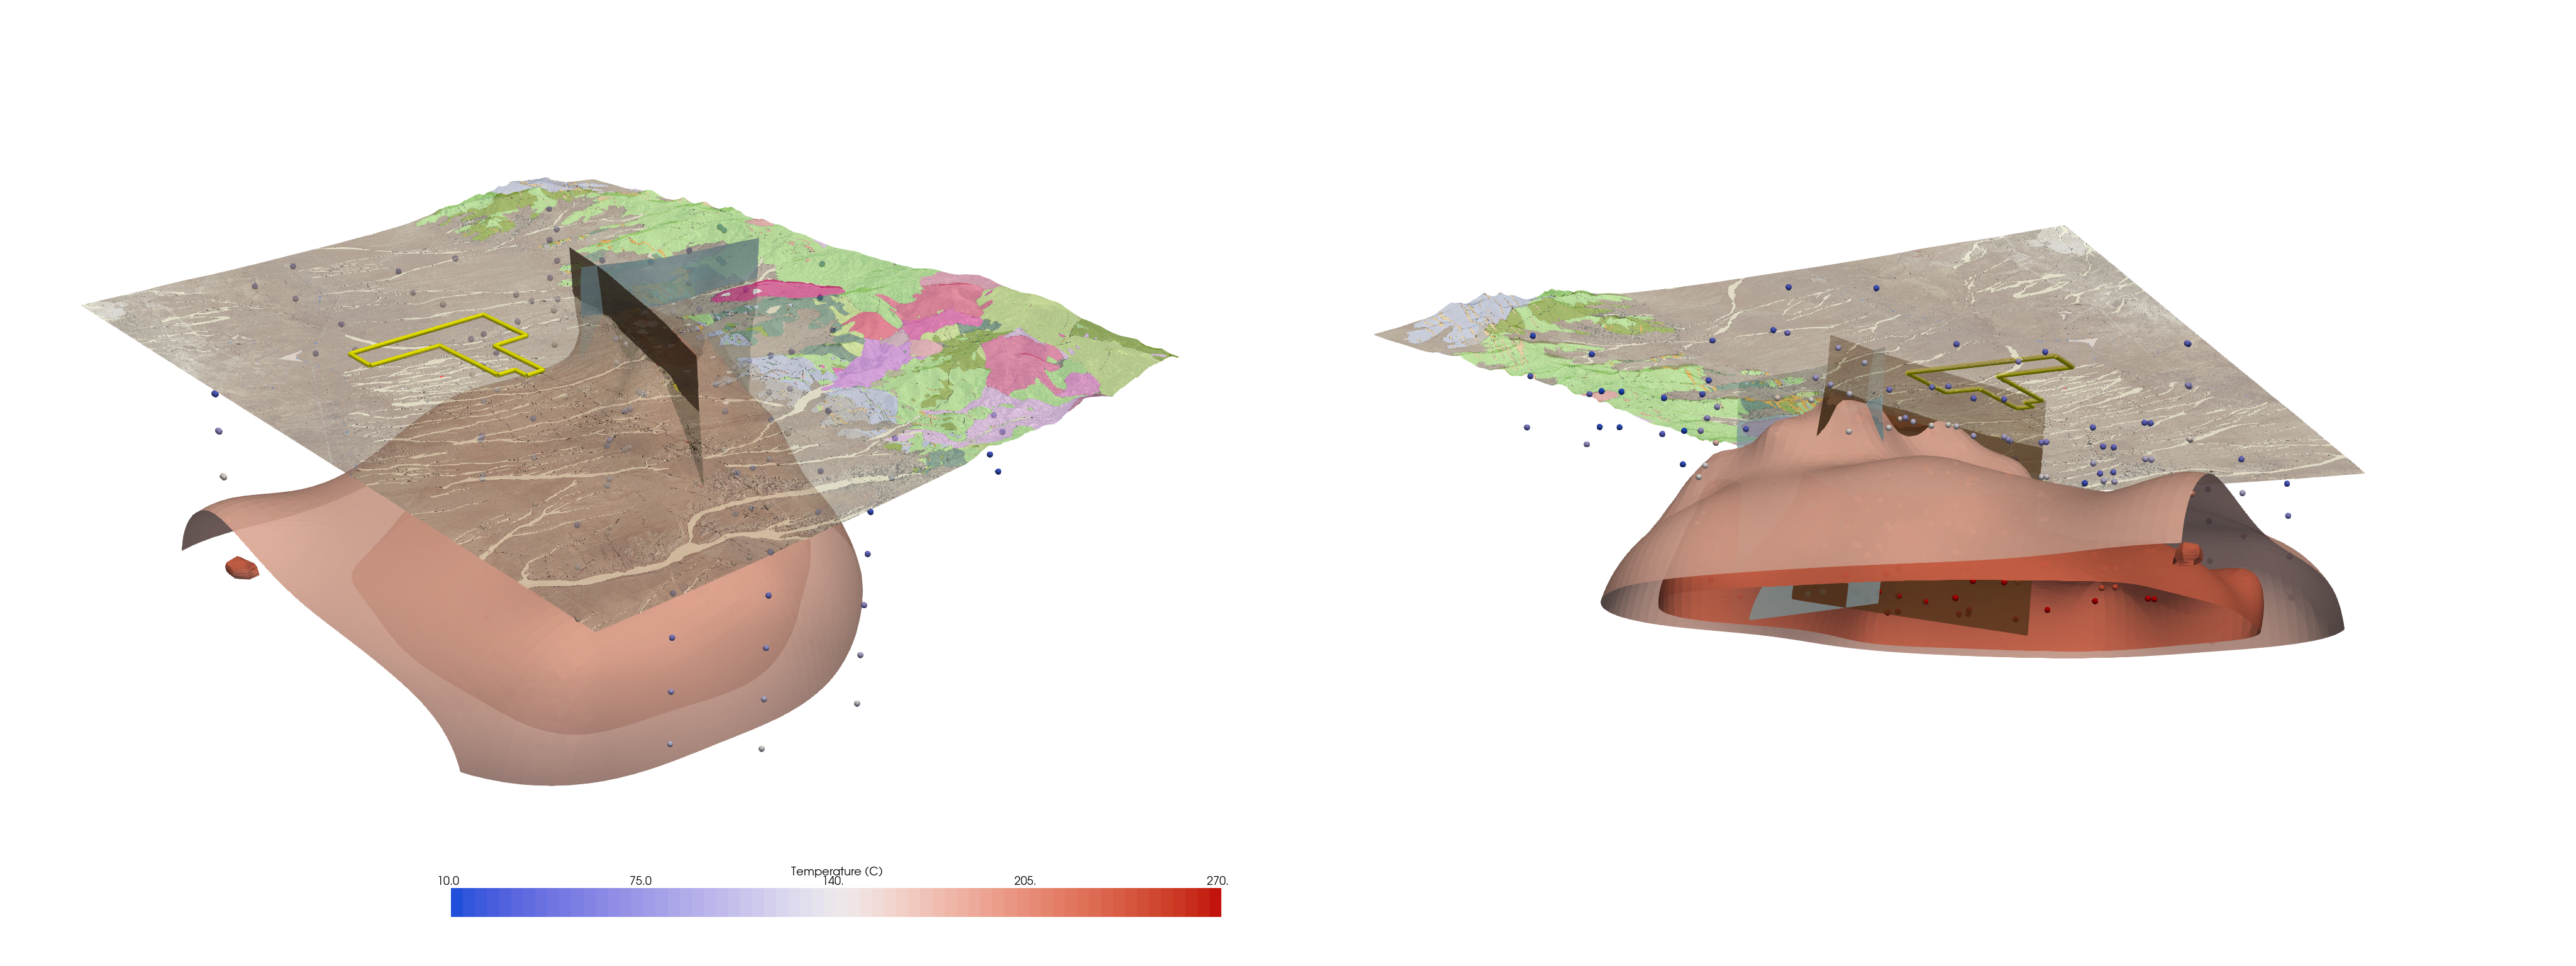

In [12]:
# Create the main figure
def add_contents(p):
    """A helper to add data to scenes."""
    p.add_mesh(project["Site Boundary"].tube(50), color="yellow",)
    p.add_mesh(project["Terrain"], texture="geo_aer", opacity=0.7, lighting=False)

    p.add_mesh(project["Opal Mound Fault"], color="brown", opacity=0.75)
    p.add_mesh(project["Negro Mag Fault"], color="lightblue", opacity=0.75)

    p.add_mesh(subsurface.contour([175, 225]), name="the model",
               scalars="temperature (C)", cmap="coolwarm", clim=[10,270], 
               opacity=0.9, stitle="Temperature (C)")
    p.add_mesh(project["Observed Temperature"], cmap="coolwarm", clim=[10,270],
               render_points_as_spheres=True, point_size=10,
               stitle="Temperature (C)")

    p.enable_anti_aliasing()
    p.enable_depth_peeling(20)
    return

p = pv.Plotter(notebook=True, border=False, 
               shape=(1,2), window_size=np.array([1024*2, 768]))
    
add_contents(p)

p.camera_position = [(315661.9406719345, 4234675.528454831, 15167.291249498076), 
                     (337498.00521202036, 4260818.504034578, -1261.5688408692681), 
                     (0.2708862567924439, 0.3397398234107863, 0.9006650255615491)]

p.subplot(0,1)
add_contents(p)

p.camera_position = [(319663.46494887985, 4294870.4704494225, -8787.973684799075), 
                     (336926.4650625, 4261892.29012, 103.0), 
                     (-0.09983848586767283, 0.20995262898057362, 0.9726007250273854)]

p.show()

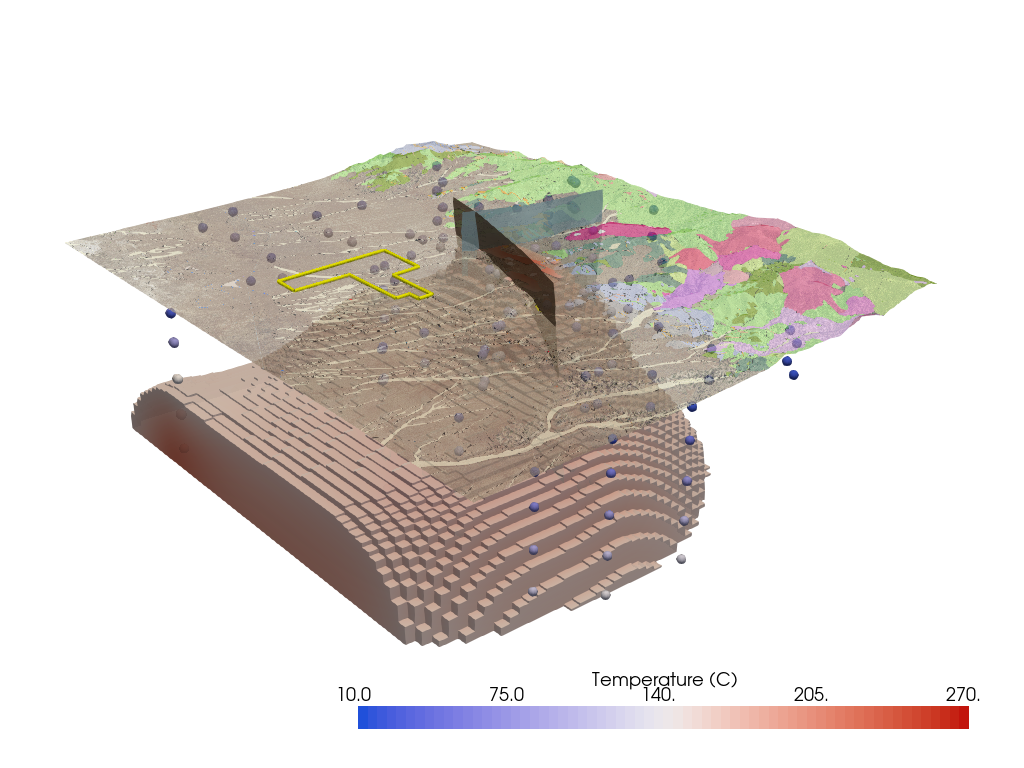

In [13]:
p = pv.Plotter(notebook=True)

add_contents(p)

p.add_mesh(subsurface.threshold(150), 
           scalars="temperature (C)", cmap="coolwarm", clim=[10,270], opacity=0.9,
           name="the model", stitle="Temperature (C)")

p.camera_position = [(315661.9406719345, 4234675.528454831, 15167.291249498076), 
                     (337498.00521202036, 4260818.504034578, -1261.5688408692681), 
                     (0.2708862567924439, 0.3397398234107863, 0.9006650255615491)]

p.show()